In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

I have always wanted to travel to Singapore. Now when one travels, the biggest cost usually comes from the flight ticket and accommodation. And I would say that although airline can make a difference in one's travel, but perhaps not as much as the accommodation, because, unless one sits in the first-class or business, it is usually not that comfortable anyway. However, for accommodation, the place one lives in can make a big difference. Therefore, my goal here is to see if I can find an optimal place that I want to travel to, i.e., what is the place that would give the highest price-performance ratio.

In [4]:
df = pd.read_csv('listings.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,49091,COZICOMFORT LONG TERM STAY ROOM 2,266763,Francesca,North Region,Woodlands,1.44255,103.79580,Private room,83,180,1,2013-10-21,0.01,2,365
1,50646,Pleasant Room along Bukit Timah,227796,Sujatha,Central Region,Bukit Timah,1.33235,103.78521,Private room,81,90,18,2014-12-26,0.28,1,365
2,56334,COZICOMFORT,266763,Francesca,North Region,Woodlands,1.44246,103.79667,Private room,69,6,20,2015-10-01,0.20,2,365
3,71609,Ensuite Room (Room 1 & 2) near EXPO,367042,Belinda,East Region,Tampines,1.34541,103.95712,Private room,206,1,14,2019-08-11,0.15,9,353
4,71896,B&B Room 1 near Airport & EXPO,367042,Belinda,East Region,Tampines,1.34567,103.95963,Private room,94,1,22,2019-07-28,0.22,9,355


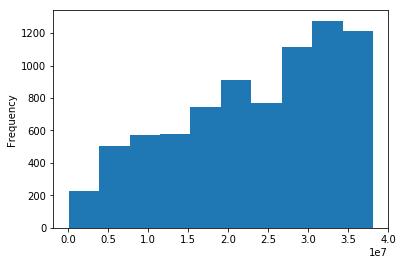

In [3]:
df['id'].plot.hist()
# thought the ID would be evenly distributed. However, this does not seem to be the case. Is it possible because earlier there was less Singaporean house listed 
# But as time goes by, the proportion of Singaporean houses increased?

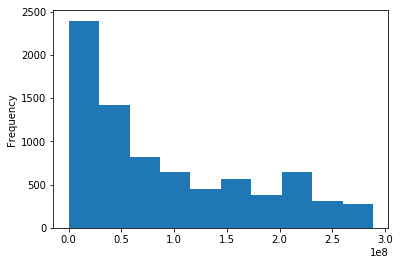

In [4]:
df['host_id'].plot.hist()
# Opposite to room id, user id frequency is left skewed. Is it because older users have more house listings?

In [5]:
def print_cat_percent(df, col, limit=""):
    uniq_key = df[col].value_counts().index
    if limit == "":
        print(df[col].value_counts())
    else:
        print(df[col].value_counts()[:limit])
    
    for ind, cat in enumerate(uniq_key):
        print("{0} percentage: {1:.1f}%".format(cat, df[col].value_counts()[cat]/len(df)*100))
        if not limit == "":
            if ind > limit:
                break
    
    print('\n####################\n')

# print(df['neighbourhood_group'].unique())
# print(df['neighbourhood_group'].value_counts().keys)
# print("Central Region percentage: {0:.1f}%".format(df['neighbourhood_group'].value_counts()['Central Region']/len(df)*100))
# print("West Region percentage: {0:.1f}%".format(df['neighbourhood_group'].value_counts()['West Region']/len(df)*100))
# print("East Region percentage: {0:.1f}%".format(df['neighbourhood_group'].value_counts()['East Region']/len(df)*100))
# print("North-East Region percentage: {0:.1f}%".format(df['neighbourhood_group'].value_counts()['North-East Region']/len(df)*100))
# print("North Region percentage: {0:.1f}%".format(df['neighbourhood_group'].value_counts()['North Region']/len(df)*100))

print_cat_percent(df, 'neighbourhood_group')
# There are 5 regions in Singapore, and most of the rooms listed is in central region. (See percentage listed below)

print_cat_percent(df, 'neighbourhood', limit=5)

Central Region       6309
West Region           540
East Region           508
North-East Region     346
North Region          204
Name: neighbourhood_group, dtype: int64
Central Region percentage: 79.8%
West Region percentage: 6.8%
East Region percentage: 6.4%
North-East Region percentage: 4.4%
North Region percentage: 2.6%

####################

Kallang    1043
Geylang     994
Novena      537
Rochor      536
Outram      477
Name: neighbourhood, dtype: int64
Kallang percentage: 13.2%
Geylang percentage: 12.6%
Novena percentage: 6.8%
Rochor percentage: 6.8%
Outram percentage: 6.0%
Bukit Merah percentage: 5.9%
Downtown Core percentage: 5.4%

####################



C:\ProgramData\Anaconda3\lib\site-packages\scipy\cluster\vq.py:523: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


[[  1.44255 103.7958 ]
 [  1.33235 103.78521]
 [  1.44246 103.79667]
 ...
 [  1.31286 103.85996]
 [  1.29543 103.83801]
 [  1.29672 103.83325]]


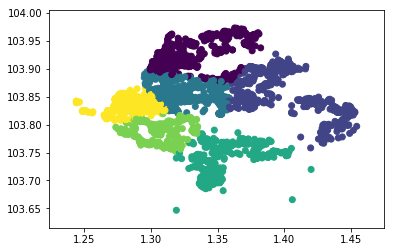

In [6]:
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans2, whiten


# Using kmeans2 to cluster geographical data
# https://stackoverflow.com/questions/568962/how-do-i-create-an-empty-array-matrix-in-numpy

# coordinates= np.array([
#            [lat, long],
#            [lat, long],
#             ...
#            [lat, long]
#            ])
coordinates = np.empty(shape=[0, 2])

for index, row in df.iterrows():
    coordinates = np.append(coordinates, [[row['latitude'], row['longitude']]], axis=0)
x, y = kmeans2(whiten(coordinates), 6, iter = 20)

print(coordinates)
plt.scatter(coordinates[:,0], coordinates[:,1], c=y);
plt.show()

## Determine the optimal K-cluster number
This is done by plotting the average within-cluster sum of squares against the number of cluster, and then find the spot where the elbow is shown.

In [7]:
# Determining the optimal k-cluster number
# https://nbviewer.jupyter.org/github/nborwankar/LearnDataScience/blob/master/notebooks/D3.%20K-Means%20Clustering%20Analysis.ipynb
# Need to adapt the code so that it can cater for 2D points
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

In [8]:
# Finding out what is the best K number for k-clustering
K = range(1,20)

# km_x, km_y = [kmeans2(whiten(coordinates), k, iter = 20) for k in K]

km = []

for k in K:
    k_cor_temp, k_group_temp = kmeans2(coordinates, k, iter = 20)
#     print('x_temp: ', k_cor_temp)
    km.append([[x[0], x[1]] for x in k_cor_temp])
#     km_y.append([y[1] for y in k_cor_temp])

# test = [cent for (cent,var) in km_x] 

# KM = [kmeans(X,k) for k in K] # apply kmeans 1 to 10
# centroids = [cent for (cent,var) in KM]   # cluster centroids

# D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
D_k = [cdist(coordinates, cent, 'euclidean') for cent in km]

# print(whiten(coordinates))
# print(km)
# print(test)

cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/coordinates.shape[0] for d in dist] 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\cluster\vq.py:523: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


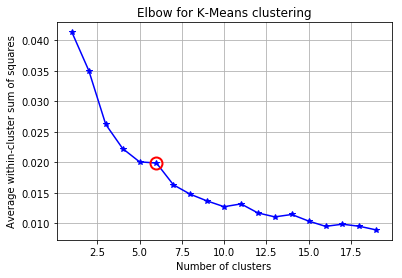

In [9]:
kIdx = 5
# plot elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
      markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
tt = plt.title('Elbow for K-Means clustering') 


In [53]:
df.groupby('neighbourhood').count()

,id,name,host_id,host_name,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,loc_encode
neighbourhood,,,,,,,,,,,,,,,,
Ang Mo Kio,58,58,58,58,58,58,58,58,58,58,58,23,23,58,58,58
Bedok,373,373,373,373,373,373,373,373,373,373,373,258,258,373,373,373
Bishan,57,56,57,57,57,57,57,57,57,57,57,33,33,57,57,57
Bukit Batok,65,65,65,65,65,65,65,65,65,65,65,37,37,65,65,65
Bukit Merah,470,469,470,470,470,470,470,470,470,470,470,267,267,470,470,470
Bukit Panjang,34,34,34,34,34,34,34,34,34,34,34,22,22,34,34,34
Bukit Timah,131,131,131,131,131,131,131,131,131,131,131,90,90,131,131,131
Central Water Catchment,34,34,34,34,34,34,34,34,34,34,34,11,11,34,34,34
Choa Chu Kang,63,63,63,63,63,63,63,63,63,63,63,41,41,63,63,63


In [46]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,loc_encode
0,49091,COZICOMFORT LONG TERM STAY ROOM 2,266763,Francesca,North Region,Woodlands,1.44255,103.79580,Private room,83,180,1,2013-10-21,0.01,2,365,1
1,50646,Pleasant Room along Bukit Timah,227796,Sujatha,Central Region,Bukit Timah,1.33235,103.78521,Private room,81,90,18,2014-12-26,0.28,1,365,4
2,56334,COZICOMFORT,266763,Francesca,North Region,Woodlands,1.44246,103.79667,Private room,69,6,20,2015-10-01,0.20,2,365,1
3,71609,Ensuite Room (Room 1 & 2) near EXPO,367042,Belinda,East Region,Tampines,1.34541,103.95712,Private room,206,1,14,2019-08-11,0.15,9,353,0
4,71896,B&B Room 1 near Airport & EXPO,367042,Belinda,East Region,Tampines,1.34567,103.95963,Private room,94,1,22,2019-07-28,0.22,9,355,0


In [78]:
###### Encode geo_loc, neighbourhood, neighbourhood_group and room-type using one-hot-encode
# The problem with OrdinaryEncoding (assigning 0 - max(val) to a category in a feature column) is that
# When training the model, one may misunderstand the data with some kind of order (0<1<2...)
# And correlate the increase in number with other features.

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

enc_col = ['loc_encode', 'neighbourhood', 'neighbourhood_group', 'room_type']

# one_hot_enc = OneHotEncoder()
# ord_enc = LabelEncoder()

# print(y.reshape(-1,1))

####### Dataframe method to perfrom one-hot encoding: #######
df['loc_encode'] = y
df_process = pd.get_dummies(df, columns=enc_col)

##### Dataframe method do ordinary label encoding: ####
# df_loc_encode = df.copy()
# df_loc_encode['loc_encode'] = pd.Categorical(y)


#### Dropping geo-loc columns####
df_process = df_process.drop(['latitude', 'longitude'], axis = 1)
df_process.head()

,id,name,host_id,host_name,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,...,neighbourhood_Woodlands,neighbourhood_Yishun,neighbourhood_group_Central Region,neighbourhood_group_East Region,neighbourhood_group_North Region,neighbourhood_group_North-East Region,neighbourhood_group_West Region,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,49091,COZICOMFORT LONG TERM STAY ROOM 2,266763,Francesca,83,180,1,2013-10-21,0.01,2,...,1,0,0,0,1,0,0,0,1,0
1,50646,Pleasant Room along Bukit Timah,227796,Sujatha,81,90,18,2014-12-26,0.28,1,...,0,0,1,0,0,0,0,0,1,0
2,56334,COZICOMFORT,266763,Francesca,69,6,20,2015-10-01,0.20,2,...,1,0,0,0,1,0,0,0,1,0
3,71609,Ensuite Room (Room 1 & 2) near EXPO,367042,Belinda,206,1,14,2019-08-11,0.15,9,...,0,0,0,1,0,0,0,0,1,0
4,71896,B&B Room 1 near Airport & EXPO,367042,Belinda,94,1,22,2019-07-28,0.22,9,...,0,0,0,1,0,0,0,0,1,0


## Date processing (last_review column)

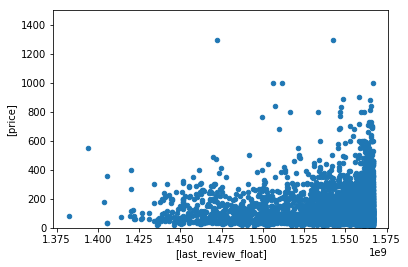

In [112]:
#### Handle last_review with datetime ####
from datetime import datetime

last_review_date = df['last_review'].apply(lambda x: datetime(int(x[0:4]), int(x[5:7]), int(x[-2:])) if isinstance(x,str) else np.nan)
last_review_float = df['last_review'].apply(lambda x: datetime(int(x[0:4]), int(x[5:7]), int(x[-2:])).timestamp() if isinstance(x,str) else np.nan)
# print(date(int(test[0:4]), int(test[5:7]), int(test[-2:])))
df_process['last_review'] = last_review_date
df_process['last_review_float'] = last_review_float

# df_process.head()

# To show if there is any trend between the last review date versus the price
# TODO need to figure out if there is a way to plot with timestamp, but the x tick value would show the date.
df_process.plot(x=['last_review_float'], y=['price'], kind='scatter', ylim=[0,1500])


<class 'numpy.float64'>


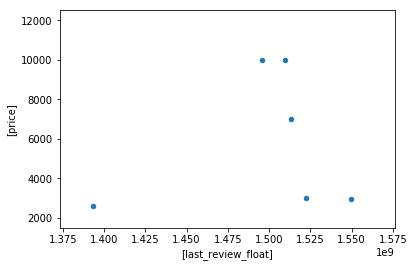

In [113]:
# The second graph is to show the outliers. There are only
df_process.plot(x=['last_review_float'], y=['price'], kind='scatter', ylim=[1500,12500])
print(type(df_process.iloc[0]['last_review_float']))

### What can be done with the datetime:
https://datascience.stackexchange.com/questions/2368/machine-learning-features-engineering-from-date-time-data
What I think can be done is to categorise the review comment based on week. i.e., using timedelta to show
how many weeks before was the last review made

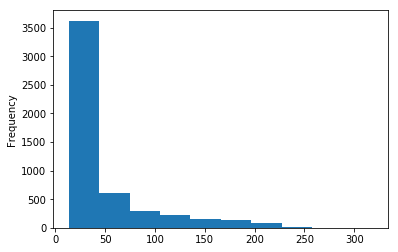

In [121]:
from sklearn.preprocessing import RobustScaler

robsut_scaler = RobustScaler()

today = datetime.now()
num_week_last_review = df_process['last_review'].apply(lambda x: (today - x).days/7\
                                                       if isinstance(x, datetime) else np.nan)
df_process['last_review_from_now_in_weeks'] = num_week_last_review
# print(num_week_last_review)

robust_scaled_last_review = scaler.fit_transform(df_process['last_review_from_now_in_weeks'])
df_process['last_review_from_now_in_weeks_scaled'] = pd.DataFrame(robust_scaled_df, columns=['x1', 'x2'])


df_process['last_review_from_now_in_weeks'].plot(kind='hist')

Since the distribution is left skewed and there seems to be outliers (perhaps the unit is no longer available?), will use Quartile normalisation method (Check http://benalexkeen.com/feature-scaling-with-scikit-learn)

## Missing value imputation


In [102]:
### Use missing indicator from sklean to identify rows with missing values
from sklearn.impute import MissingIndicator

indicator = MissingIndicator(missing_values=np.NaN)
test_miss_indictator = indicator.fit_transform(df_process)
print(test_miss_indicator_)

ValueError: could not convert string to float: 'Terence'

In [ ]:
print(df[df])

In [ ]:
### Normalising the host id. The reason is because the order is important, but I want to reduce the scaling effect
# Try using binning to make ID, host ID into categories?


It can be seen from the last elbow graph that k-cluster = 6 is a good number to use.
Run kmeans 2 with k-cluster number = 6 and assign the groups to a df column with name 'loc_encode'

## Next step: use Pipeline to do the feature transformation (including geo feature drop and re-assign k-cluster number)

In [42]:
#######
# Reassign geo information as K-cluster numbre and drop the latitude and longitude columns
#######



,id,name,host_id,host_name,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,loc_encode_0,loc_encode_1,loc_encode_2,loc_encode_3,loc_encode_4,loc_encode_5
0,49091,COZICOMFORT LONG TERM STAY ROOM 2,266763,Francesca,North Region,Woodlands,Private room,83,180,1,2013-10-21,0.01,2,365,0,1,0,0,0,0
1,50646,Pleasant Room along Bukit Timah,227796,Sujatha,Central Region,Bukit Timah,Private room,81,90,18,2014-12-26,0.28,1,365,0,0,0,0,1,0
2,56334,COZICOMFORT,266763,Francesca,North Region,Woodlands,Private room,69,6,20,2015-10-01,0.20,2,365,0,1,0,0,0,0
3,71609,Ensuite Room (Room 1 & 2) near EXPO,367042,Belinda,East Region,Tampines,Private room,206,1,14,2019-08-11,0.15,9,353,1,0,0,0,0,0
4,71896,B&B Room 1 near Airport & EXPO,367042,Belinda,East Region,Tampines,Private room,94,1,22,2019-07-28,0.22,9,355,1,0,0,0,0,0
